In [1]:
from PIL import Image
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, figure
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
import random

In [2]:
%%capture
import tensorflow, keras

In [3]:
print('Tensorflow version: '+ tensorflow.__version__ + '\n' + \
      'Keras version: '+ keras.__version__)
from keras.models import Sequential, Input, Model
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Tensorflow version: 1.5.1
Keras version: 2.1.6


## Functions

In [4]:
def PIL_resize(path_to_image, resize_to=(200, 200), quality_=100, 
               img_show = False, img_save=True, show_from_file=False):
    im = Image.open(path_to_image) # read image
    f, e = os.path.splitext(path_to_image) # split image path to path and .jpg
    im_resize = im.resize(resize_to, Image.ANTIALIAS) # resize image
    if (img_save & ~(show_from_file)):
        im_resize.save(f + '.jpg', 'JPEG', quality=quality_) # save image
    if img_show:
        display(im_resize)
    if show_from_file:
        im_resize.save(f + 'temp.jpg', 'JPEG', quality=quality_)
        imshow(np.asarray(Image.open(f + 'temp.jpg')))
        os.remove(f + 'temp.jpg')
    if (img_save & show_from_file):
        print('To overwrite the file select img_save=True & show_from_file=False')

## Get paths

In [5]:
paths = "/home/chrysa/google_photos/pictures/"
dirs = os.listdir(paths)
paths = [paths + fl + '/' for fl in dirs if fl[0] != "."]

In [6]:
paths

['/home/chrysa/google_photos/pictures/livingroom/',
 '/home/chrysa/google_photos/pictures/kitchen traditional/',
 '/home/chrysa/google_photos/pictures/bathroom old/',
 '/home/chrysa/google_photos/pictures/kitchen cozy/',
 '/home/chrysa/google_photos/pictures/bedroom/',
 '/home/chrysa/google_photos/pictures/living room/',
 '/home/chrysa/google_photos/pictures/kitchen/',
 '/home/chrysa/google_photos/pictures/bathroom/',
 '/home/chrysa/google_photos/pictures/kitchen modern/']

## Get img sizes and paths

In [7]:
%%capture

sizes = defaultdict(list)
imgs = defaultdict(list)
for path in paths:
    pics = os.listdir(path)
    for pic in pics:
        try:
            sizes[path.split('/')[-2]].append(Image.open(path+pic).size)
            imgs[path.split('/')[-2]].append(path+pic)
        except:
            pass

## Plot the aspect ratio

In [8]:
sizes.keys()

dict_keys(['livingroom', 'kitchen traditional', 'bathroom old', 'kitchen cozy', 'bedroom', 'living room', 'kitchen', 'bathroom', 'kitchen modern'])

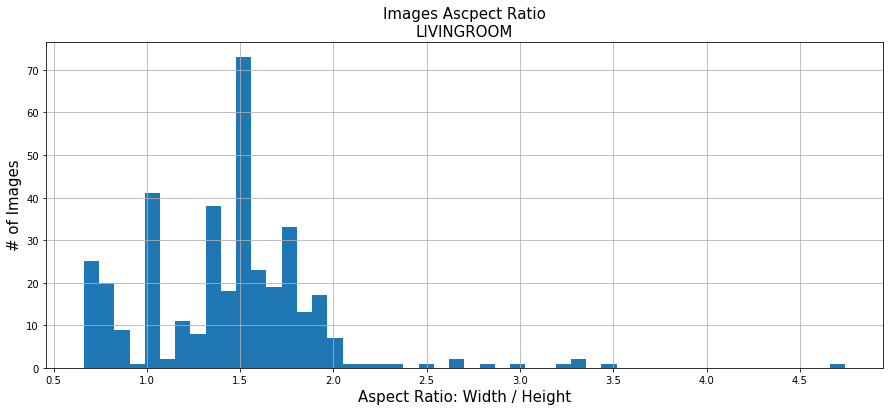

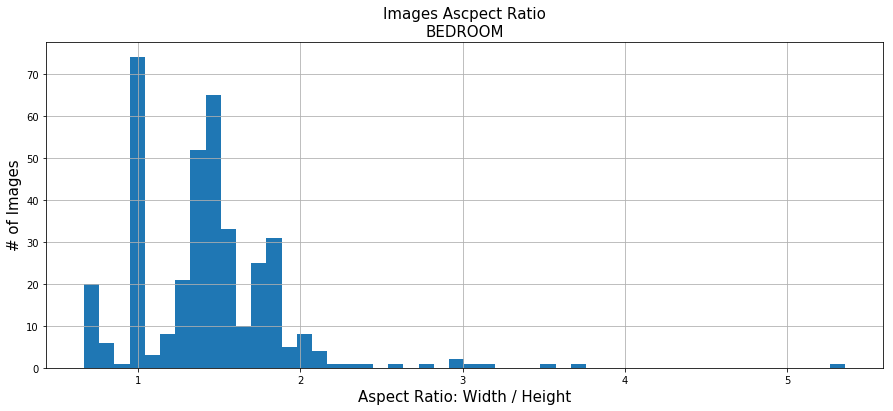

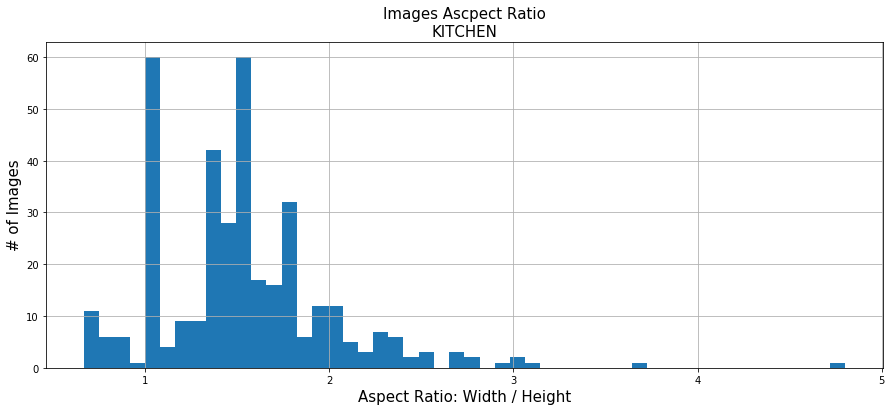

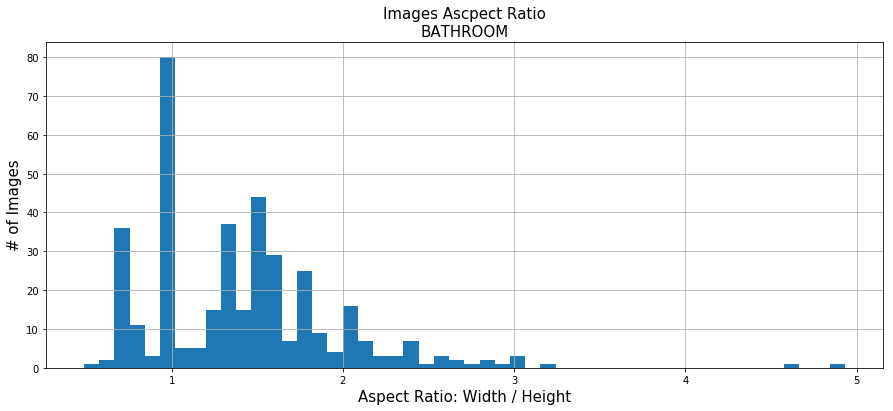

In [9]:
for k, v in sizes.items():
    if (k in ['livingroom', 'bedroom', 'laundry room', 'bathroom', 'kitchen']):
        df_tmp = pd.DataFrame(sizes[k], columns=['width', 'height'])
        plt.figure()
        (df_tmp.width / df_tmp.height).hist(bins = 50, figsize=(15, 6))
        plt.xlabel('Aspect Ratio: Width / Height', fontsize=15)
        plt.ylabel('# of Images', fontsize=15)
        plt.title('Images Ascpect Ratio\n' + k.upper(), fontsize=15)

## Resizing images

In [10]:
removed_imgs = defaultdict(int)
for k, pic_urls in imgs.items():
    print('-- Running for: ' + str(k))
    for i, pic_url in enumerate(pic_urls):
        if not(i % 150):
            print('-- resized: ' + str(i) + ' of ' + str(len(pic_urls)))
        try:
            PIL_resize(path_to_image=pic_url, resize_to=(100,100), quality_=100, 
                       img_show=False, img_save=True, show_from_file=False)
        except:
            removed_imgs[k] += 1
            os.remove(pic_url)

-- Running for: livingroom
-- resized: 0 of 358
-- resized: 150 of 358
-- resized: 300 of 358
-- Running for: kitchen traditional
-- resized: 0 of 360
-- resized: 150 of 360
-- resized: 300 of 360
-- Running for: bathroom old
-- resized: 0 of 358
-- resized: 150 of 358
-- resized: 300 of 358
-- Running for: kitchen cozy
-- resized: 0 of 339
-- resized: 150 of 339
-- resized: 300 of 339
-- Running for: bedroom
-- resized: 0 of 376
-- resized: 150 of 376
-- resized: 300 of 376
-- Running for: living room
-- resized: 0 of 261
-- resized: 150 of 261
-- Running for: kitchen
-- resized: 0 of 359
-- resized: 150 of 359
-- resized: 300 of 359
-- Running for: bathroom
-- resized: 0 of 374
-- resized: 150 of 374
-- resized: 300 of 374
-- Running for: kitchen modern
-- resized: 0 of 166
-- resized: 150 of 166


In [11]:
# Images removed
removed_imgs

defaultdict(int, {})

In [12]:
sum(removed_imgs.values())

0

## View image

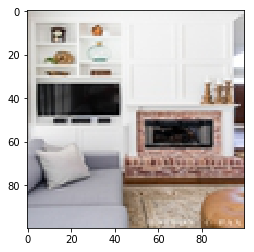

In [13]:
imshow(np.asarray(Image.open(imgs['livingroom'][120])));

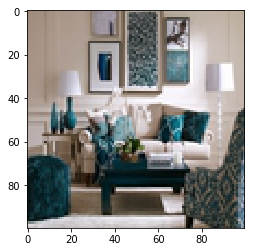

In [14]:
PIL_resize(path_to_image=imgs['livingroom'][11], resize_to=(100,100), quality_=100, 
                       img_show=False, img_save=False, show_from_file=True)

### Reshape images

<img src='https://preview.ibb.co/f1rvxy/reshape_img.jpg'>

<b>Min - Max Normalize </b><br>
$z_i=\cfrac{x_i-\min(x)}{\max(x)-\min(x)}$ for `RBG` its $z_i=\cfrac{x_i-0}{255-0} \Rightarrow z_i=\cfrac{x_i}{255}$

In [15]:
# Get number of images
imgs_count = 0
for k in imgs.keys():
    imgs_count += len(imgs[k])

In [16]:
### How many pixels / RGB do we have per image
img = np.asarray(Image.open(imgs[k][0]))
img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2], 1)
img.shape[0]

30000

In [17]:
### how many images
imgs_count

2951

In [18]:
### initial matrix X of dimantions n, m where n is the number of pixels * rgb colours and m are the number of images
X = np.zeros((img.shape[0], imgs_count))
### I am going to store the labeled data of the image in Y
Y = list()

In [19]:
### For every image we have stored create respective X and Y
i = 0
cntr = 0
num_of_imgs = 0 
### k is the folder where we have the image stored
### pic_urls are the paths of the images we have in the k folder
for k, pic_urls in imgs.items():
    print('-- Running for: ' + str(k))
    ### for every image 
    for pic_url in pic_urls:
        num_of_imgs += 1
        ### open the image
        try:
            img = np.asarray(Image.open(pic_url))
            ### convert the image to a vector of size x_pixels * y_pixels * 3, 1 and store it
            ### in the respective column of matrix X. 
            ### For example the first imgae in going to be stored in the first column of X
            X[:, i] = img.reshape(img.shape[0] * img.shape[1] * img.shape[2]) / 255
            ### append the folder name in which the image was saved
            Y.append(k)
            i += 1
        except:
            cntr += 1

-- Running for: livingroom
-- Running for: kitchen traditional
-- Running for: bathroom old
-- Running for: kitchen cozy
-- Running for: bedroom
-- Running for: living room
-- Running for: kitchen
-- Running for: bathroom
-- Running for: kitchen modern


In [20]:
print(cntr)

3


In [21]:
X.shape

(30000, 2951)

In [22]:
print(num_of_imgs)
print(len(Y))

2951
2948


In [23]:
X.shape[1] - len(Y)

3

In [24]:
# Remove broken images
X = X[: , :(X.shape[1] - cntr)]

In [25]:
### Recode Y
map_Y = {
'bathroom': 'bathroom',
'bathroom classy': 'bathroom',
'bathroom contemporary': 'bathroom',
'bathroom industrial': 'bathroom',
'bathroom modern': 'bathroom',
'bathroom old': 'bathroom',
'bathroom small': 'bathroom',
'bathroom small space': 'bathroom',
'bathroom traditional': 'bathroom',
'bathroom vintage': 'bathroom',
'bedroom': 'bedroom',
'bedroom classy': 'bedroom',
'bedroom comfy': 'bedroom',
'bedroom contemporary': 'bedroom',
'bedroom cozy': 'bedroom',
'bedroom industrial': 'bedroom',
'bedroom modern': 'bedroom',
'bedroom neutral': 'bedroom',
'bedroom traditional': 'bedroom',
'bedroom vintage': 'bedroom',
'kitchen': 'kitchen',
'kitchen contemporary': 'kitchen',
'kitchen country': 'kitchen',
'kitchen cozy': 'kitchen',
'kitchen industrial': 'kitchen',
'kitchen modern': 'kitchen',
'kitchen oak cabinets': 'kitchen',
'kitchen rustic': 'kitchen',
'kitchen traditional': 'kitchen',
'kitchen vintage': 'kitchen',
'laundry room': 'laundry',
'laundry room ': 'laundry',
'laundry room compact': 'laundry',
'laundry room in house': 'laundry',
'laundry room normal': 'laundry',
'laundry room old': 'laundry',
'laundry room small': 'laundry',
'laundry room small house': 'laundry',
'laundry room small space': 'laundry',
'laundry room tiny': 'laundry',
'living room': 'livingroom',
'living room classy': 'livingroom',
'living room comfy': 'livingroom',
'living room contemporary': 'livingroom',
'living room cozy': 'livingroom',
'living room industrial': 'livingroom',
'living room modern': 'livingroom',
'living room neutral': 'livingroom',
'living room traditional': 'livingroom',
'living room vintage': 'livingroom',
'livingroom': 'livingroom'}
Y = [map_Y[el] for el in Y]

In [26]:
set(Y)

{'bathroom', 'bedroom', 'kitchen', 'livingroom'}

In [27]:
print(X.shape)
print(len(Y))

(30000, 2948)
2948


### Save X and Y

In [28]:
np.save('X', X)
np.save('Y', Y)

### Load X and Y

In [29]:
X = np.load('X.npy')
Y = np.load('Y.npy')

### Logistic Regressions

You will first test a <b>Logistic Regression</b> activation function, using a Neural Network mindset.<br>
<img src='https://preview.ibb.co/dAoscy/logistic_reg.jpg' style='width: 2px;'/>

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
Steps we will follow: 
    - Initialize the parameters of the model
    - Learn the parameters for the model by minimizing the cost  
    - Use the learned parameters to make predictions (on the test set)
    - Analyse results

#### Helper functions

**Sigmoid**: $sigmoid( w^T x + b) = \cfrac{1}{1 + e^{-(w^T x + b)}}$

In [30]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

**Initializing parameters:** You will initialize `w` as a vector of zeros.

In [31]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros(dim).reshape(dim, 1)
    b = 0.0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

**Forward and Backward propagation** We use the following cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

In [32]:
def propagate(w, b, X, Y):
    """
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-kitchen, 1 if kitchen) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T, X) + b)                                # compute activation
    cost = - 1/m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))              # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

**Optimization:** Our goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [33]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate * dw
        b = b - learning_rate * db

        
        # Record the costs
        if i % 500 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

**Predicting** Predicting the outcome

In [34]:
def predict(w, b, X, threshold=0.5):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = (A[0, i] > threshold) * 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

**Merging all functions into a model**

In [35]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the helper functions
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations = num_iterations, 
                                        learning_rate = learning_rate, print_cost = print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    # Print train/test Errors/confusion metrics
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    print('Precision: is acuracy of possitive predictions')
    print('Recall: fraction of positives that where correctly identified')
    print(metrics.classification_report(Y_test[0], Y_prediction_test.astype(int)[0]))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

### Running Logistic regression model

### Kitchen

In [36]:
# Recode Y to 0 and 1
room = 'kitchen'
Y_ = [(rm == room)*1 for rm in Y]

### Split training and test set

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [38]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [39]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1975)
y_train:  (1, 1975)
Train Rooms:  0.41265822784810124
X_test:  (30000, 973)
y_test:  (1, 973)
Test Rooms:  0.4193216855087359


In [40]:
kitchen = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.672540
Cost after iteration 1000: 0.628959
Cost after iteration 1500: 0.596632
Cost after iteration 2000: 0.568420
Cost after iteration 2500: 0.542825
Cost after iteration 3000: 0.519230
Cost after iteration 3500: 0.497320
Cost after iteration 4000: 0.477352
Cost after iteration 4500: 0.463912
Cost after iteration 5000: 0.454472
Cost after iteration 5500: 0.445602
Cost after iteration 6000: 0.437230
Cost after iteration 6500: 0.429298
Cost after iteration 7000: 0.421759
Cost after iteration 7500: 0.414574
Cost after iteration 8000: 0.407711
Cost after iteration 8500: 0.401139
Cost after iteration 9000: 0.394836
Cost after iteration 9500: 0.388780
train accuracy: 86.8860759493671 %
test accuracy: 65.26207605344297 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.67      0.79      0.73       56

### Bedroom

In [41]:
# Recode Y to 0 and 1
room = 'bedroom'
Y_ = [(rm == room)*1 for rm in Y]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [43]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [44]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1975)
y_train:  (1, 1975)
Train Rooms:  0.12556962025316457
X_test:  (30000, 973)
y_test:  (1, 973)
Test Rooms:  0.131551901336074


In [45]:
bedroom = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.323924
Cost after iteration 1000: 0.304554
Cost after iteration 1500: 0.291038
Cost after iteration 2000: 0.279913
Cost after iteration 2500: 0.270243
Cost after iteration 3000: 0.261611
Cost after iteration 3500: 0.253783
Cost after iteration 4000: 0.246606
Cost after iteration 4500: 0.239972
Cost after iteration 5000: 0.233803
Cost after iteration 5500: 0.228035
Cost after iteration 6000: 0.222619
Cost after iteration 6500: 0.217514
Cost after iteration 7000: 0.212686
Cost after iteration 7500: 0.208107
Cost after iteration 8000: 0.203754
Cost after iteration 8500: 0.199605
Cost after iteration 9000: 0.195643
Cost after iteration 9500: 0.191852
train accuracy: 93.16455696202532 %
test accuracy: 85.61151079136691 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.87      0.98      0.92       8

### Bathroom

In [46]:
# Recode Y to 0 and 1
room = 'bathroom'
Y_ = [(rm == room)*1 for rm in Y]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [48]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [49]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1975)
y_train:  (1, 1975)
Train Rooms:  0.24962025316455697
X_test:  (30000, 973)
y_test:  (1, 973)
Test Rooms:  0.24357656731757452


In [50]:
bathroom = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.498003
Cost after iteration 1000: 0.477571
Cost after iteration 1500: 0.461704
Cost after iteration 2000: 0.448300
Cost after iteration 2500: 0.436563
Cost after iteration 3000: 0.426059
Cost after iteration 3500: 0.416518
Cost after iteration 4000: 0.407753
Cost after iteration 4500: 0.399633
Cost after iteration 5000: 0.392058
Cost after iteration 5500: 0.384953
Cost after iteration 6000: 0.378258
Cost after iteration 6500: 0.371924
Cost after iteration 7000: 0.365912
Cost after iteration 7500: 0.360188
Cost after iteration 8000: 0.354724
Cost after iteration 8500: 0.349496
Cost after iteration 9000: 0.344484
Cost after iteration 9500: 0.339671
train accuracy: 86.8860759493671 %
test accuracy: 71.53134635149024 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.78      0.87      0.82       73

### Living Room

In [51]:
# Recode Y to 0 and 1
room = 'livingroom'
Y_ = [(rm == room)*1 for rm in Y]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [53]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [54]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1975)
y_train:  (1, 1975)
Train Rooms:  0.21215189873417722
X_test:  (30000, 973)
y_test:  (1, 973)
Test Rooms:  0.20554984583761562


In [55]:
livingroom = model(X_train, y_train, X_test, y_test, num_iterations = 10000, learning_rate = 0.001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.447358
Cost after iteration 1000: 0.421760
Cost after iteration 1500: 0.401972
Cost after iteration 2000: 0.385580
Cost after iteration 2500: 0.371483
Cost after iteration 3000: 0.359055
Cost after iteration 3500: 0.347901
Cost after iteration 4000: 0.337758
Cost after iteration 4500: 0.328439
Cost after iteration 5000: 0.319808
Cost after iteration 5500: 0.311764
Cost after iteration 6000: 0.304225
Cost after iteration 6500: 0.297128
Cost after iteration 7000: 0.290423
Cost after iteration 7500: 0.284067
Cost after iteration 8000: 0.278026
Cost after iteration 8500: 0.272269
Cost after iteration 9000: 0.266773
Cost after iteration 9500: 0.261515
train accuracy: 91.24050632911393 %
test accuracy: 77.80061664953752 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.82      0.92      0.87       7

## With hidden layers

We will have one hidden layers with 5 neurans. <br> - The activation function for the hidden layer will be $tanh$. <br> - Tha activation function for the output will again be a $signmoid$

#### Helper functions

In [56]:
def layer_sizes(X, Y, n_h=5):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0] # size of input layer
    n_h = n_h
    n_y = Y.shape[0] # size of output layer

    return (n_x, n_h, n_y)

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = 1 / (1 + np.exp(-Z2))
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) + np.multiply(np.log(1-A2),1-Y)
    cost = -(1/m) * np.sum(logprobs) 
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate= 0.001, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x=n_x, n_h=n_h, n_y=n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X=X, parameters=parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2=A2, Y=Y, parameters=parameters)
        
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters=parameters, cache=cache, X=X, Y=Y)
        
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters=parameters, grads=grads, learning_rate = learning_rate)
        
        # Print the cost every 500 iterations
        if print_cost and i % 500 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

def predict(parameters, X_train, Y_train, X_test, Y_test, threeshold=0.5):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    Y -- actual, labeled
    threeshold -- cut of of sigmoid
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X=X_test, parameters=parameters)
    predictions = (A2 > threeshold) * 1
       
    # Print train/test Errors/confusion metrics
    print("train accuracy: {} %".format(100 - \
            np.mean(np.abs((forward_propagation(X=X_train, parameters=parameters)[0] > threeshold) - \
                           Y_train[0])) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(predictions[0] - Y_test)) * 100))
    print('Precision: is acuracy of possitive predictions')
    print('Recall: fraction of positives that where correctly identified')
    print(metrics.classification_report(Y_test[0], predictions[0]))
    
    return predictions

### Kitchen 2

In [57]:
# Recode Y to 0 and 1
room = 'kitchen'
Y_ = [(rm == room)*1 for rm in Y]

#### Split training and test set

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X.T, Y_, test_size=0.33, random_state=42)

In [59]:
X_train = X_train.T
X_test = X_test.T
y_train = np.array(y_train).reshape(1, len(y_train))
y_test = np.array(y_test).reshape(1, len(y_test))

In [60]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('Train Rooms: ', np.mean(y_train))
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)
print('Test Rooms: ', np.mean(y_test))

X_train:  (30000, 1975)
y_train:  (1, 1975)
Train Rooms:  0.41265822784810124
X_test:  (30000, 973)
y_test:  (1, 973)
Test Rooms:  0.4193216855087359


In [61]:
kitchen = nn_model(X=X_train, Y=y_train, n_h = 5, num_iterations = 10000, learning_rate = 0.001)

In [62]:
_ = predict(parameters=kitchen, X_train=X_train, Y_train=y_train, 
                     X_test=X_test, Y_test=y_test, threeshold=0.45)

train accuracy: 78.48101265822785 %
test accuracy: 65.87872559095581 %
Precision: is acuracy of possitive predictions
Recall: fraction of positives that where correctly identified
             precision    recall  f1-score   support

          0       0.69      0.74      0.72       565
          1       0.60      0.54      0.57       408

avg / total       0.65      0.66      0.66       973



### Convolution Neural networks

Based on the <a href="https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python">blog post</a>

<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/Typical_cnn_kecdep.png">

Subsampling helps in reducing overfiting
<img src="http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1512486717/max-pooling_tkk5n2.png">

### Importing the data

We will convert each image into greyscale of size 100 x 100 and then into a matrix of size 100 x 100 x 1 which is fed into the network.

In [63]:
X.shape

(30000, 2948)

In [64]:
samples = X.shape[1] # how many images do we have

In [65]:
### initial matrix X of dimantions n, m where n is the number of pixels * rgb colours and m are the number of images
X = np.full((samples, 100, 100, 1),0.0)
### I am going to store the labeled data of the image in Y
Y = list()

In [66]:
### For every image we have stored create respective X and Y
i = 0
### k is the folder where we have the image stored
### pic_urls are the paths of the images we have in the k folder
for k, pic_urls in imgs.items():
    print('-- Running for: ' + str(k))
    ### for every image 
    for pic_url in pic_urls:
        ### open the image and reshape to 100 X 100 X 1
        try:
            img = np.asarray(Image.open(pic_url).convert('L')).reshape(100, 100, 1)
            ### For example the first imgae in going to be stored in the first column of X
            X[i] = img / 255.0
            ### append the folder name in which the image was saved
            Y.append(k)
            i += 1
        except:
            pass
        
print(X.shape)
print(len(Y))

-- Running for: livingroom
-- Running for: kitchen traditional
-- Running for: bathroom old
-- Running for: kitchen cozy
-- Running for: bedroom
-- Running for: living room
-- Running for: kitchen
-- Running for: bathroom
-- Running for: kitchen modern
(2948, 100, 100, 1)
2948


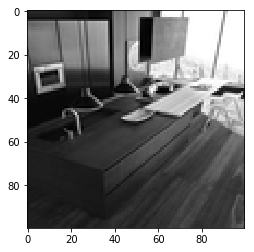

In [67]:
# greyscale image
imshow(Image.open(pic_url).convert('LA'));

In [68]:
## Check that X is populated
X[99][:2, 0]

array([[0.92156863],
       [0.92156863]])

In [69]:
### Recode Y
map_Y = {
 'bathroom':'bathroom',
 'bathroom old':'bathroom',
 'bedroom':'bedroom',
 'kitchen':'kitchen',
 'kitchen cozy':'kitchen',
 'kitchen modern':'kitchen',
 'kitchen traditional':'kitchen',
 'living room':'livingroom',
 'livingroom':'livingroom'}
Y = [map_Y[el] for el in Y]

In [70]:
### Recode Y
map_Y = {
 'bathroom': 0,
 'bedroom': 1,
 'kitchen': 2,
 'livingroom': 3
}
Y_ = [map_Y[el] for el in Y]

In [71]:
classes = np.unique(Y_)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  4
Output classes :  [0 1 2 3]


In [72]:
X.shape

(2948, 100, 100, 1)

In [73]:
len(Y_)

2948

In [74]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y_, test_size=0.15, random_state=42)
train_Y = np.array(train_Y)
test_Y = np.array(test_Y)
print('train_X: ' + str(train_X.shape))
print('train_Y: ' + str(train_Y.shape))
print('test_X: ' + str(test_X.shape))
print('test_Y: ' + str(test_Y.shape))

train_X: (2505, 100, 100, 1)
train_Y: (2505,)
test_X: (443, 100, 100, 1)
test_Y: (443,)


In [75]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

In [76]:
# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0.]


For the train further split to <code>train</code> and <code>validate</code>

In [77]:
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                           test_size=0.2, random_state=13)

In [78]:
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((2004, 100, 100, 1), (501, 100, 100, 1), (2004, 4), (501, 4))

We will use three convolutional layers: <br>

* The first layer will have 32-3 x 3 filters,
* The second layer will have 64-3 x 3 filters and
* The third layer will have 128-3 x 3 filters.<br>

In addition, there are three max-pooling layers each of size 2 x 2.

<img src="https://image.ibb.co/iWJuBd/conv.jpg">

In [79]:
batch_size = 64
epochs = 10
num_classes = nClasses

We will be using the `Leaky ReLU` as the activation function

<img src="https://cdn-images-1.medium.com/max/1600/1*LXlJ4zDmYGg9yymgFzyOdA.png">

In [80]:
img_model = Sequential()
img_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear',
                     input_shape=(100, 100 , 1), padding='same'))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D((2, 2),padding='same'))
img_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.01))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Flatten())
img_model.add(Dense(128, activation='linear'))
img_model.add(LeakyReLU(alpha=0.01))
img_model.add(Dense(num_classes, activation='softmax'))

### Compiling the Model

In [81]:
img_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [82]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       73856     
__________

### Training the Model

In [83]:
img_train = img_model.fit(train_X, train_label, batch_size=batch_size,
                          epochs=epochs,verbose=1,
                          validation_data=(valid_X, valid_label))

Train on 2004 samples, validate on 501 samples
Epoch 1/10
2004/2004 [==============================] - 30s 15ms/step - loss: 1.3393 - acc: 0.3982 - val_loss: 1.2720 - val_acc: 0.3792
Epoch 2/10
2004/2004 [==============================] - 29s 14ms/step - loss: 1.1265 - acc: 0.5225 - val_loss: 1.0651 - val_acc: 0.5529
Epoch 3/10
2004/2004 [==============================] - 29s 14ms/step - loss: 0.9939 - acc: 0.5883 - val_loss: 0.9767 - val_acc: 0.6088
Epoch 4/10
2004/2004 [==============================] - 29s 14ms/step - loss: 0.9147 - acc: 0.6357 - val_loss: 0.9932 - val_acc: 0.5768
Epoch 5/10
2004/2004 [==============================] - 29s 14ms/step - loss: 0.8198 - acc: 0.6751 - val_loss: 0.8717 - val_acc: 0.6407
Epoch 6/10
2004/2004 [==============================] - 29s 14ms/step - loss: 0.7213 - acc: 0.7116 - val_loss: 0.8387 - val_acc: 0.6727
Epoch 7/10
2004/2004 [==============================] - 29s 14ms/step - loss: 0.6128 - acc: 0.7670 - val_loss: 0.8745 - val_acc: 0.6647
E

The model is overfitting, as the validation loss is 0.9346 and the validation accuracy is a meer 71.26%.<br> 
Overfitting gives an intuition that the network has memorized the training data very well but is not guaranteed to work on unseen data, and that is why there is a difference in the training and validation accuracy.

### Model Evaluation

In [84]:
test_eval = img_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [85]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9844803915066859
Test accuracy: 0.6749435668605176


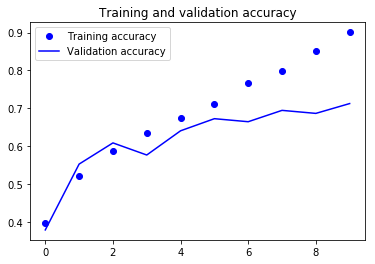

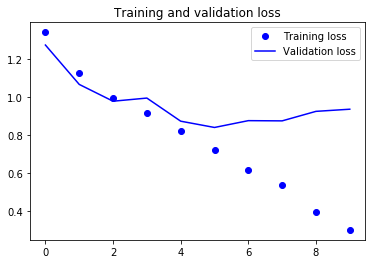

In [86]:
accuracy = img_train.history['acc']
val_accuracy = img_train.history['val_acc']
loss = img_train.history['loss']
val_loss = img_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

From the above two plots, we can see that the validation accuracy almost became stagnant after 4-5 epochs and rarely increased at certain epochs.

The validation loss shows that this is the sign of overfitting, similar to validation accuracy it linearly decreased but after 4-5 epochs, it started to increase. This means that the model tried to memorize the data and succeeded.

With this in mind, it's time to introduce some dropout into our model and see if it helps in reducing overfitting.

### Adding Dropout into the Network

In [87]:
batch_size = 64
epochs = 10
num_classes = nClasses

In [88]:
img_model = Sequential()
img_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(100,100,1)))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D((2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.1))                  
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.4))
img_model.add(Flatten())
img_model.add(Dense(128, activation='linear'))
img_model.add(LeakyReLU(alpha=0.1))           
img_model.add(Dropout(0.3))
img_model.add(Dense(num_classes, activation='softmax'))

In [89]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [90]:
img_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [91]:
img_train_dropout = img_model.fit(train_X, train_label, batch_size=batch_size,
                    epochs=epochs,verbose=1, validation_data=(valid_X, valid_label))

Train on 2004 samples, validate on 501 samples
Epoch 1/10
2004/2004 [==============================] - 34s 17ms/step - loss: 1.4482 - acc: 0.3513 - val_loss: 1.3139 - val_acc: 0.4271
Epoch 2/10
2004/2004 [==============================] - 34s 17ms/step - loss: 1.2911 - acc: 0.4072 - val_loss: 1.3419 - val_acc: 0.2595
Epoch 3/10
2004/2004 [==============================] - 34s 17ms/step - loss: 1.1891 - acc: 0.4900 - val_loss: 1.4293 - val_acc: 0.3713
Epoch 4/10
2004/2004 [==============================] - 33s 17ms/step - loss: 1.0588 - acc: 0.5763 - val_loss: 1.1043 - val_acc: 0.5309
Epoch 5/10
2004/2004 [==============================] - 34s 17ms/step - loss: 0.9363 - acc: 0.6317 - val_loss: 0.8766 - val_acc: 0.6627
Epoch 6/10
2004/2004 [==============================] - 34s 17ms/step - loss: 0.8355 - acc: 0.6662 - val_loss: 0.8636 - val_acc: 0.6547
Epoch 7/10
2004/2004 [==============================] - 34s 17ms/step - loss: 0.7823 - acc: 0.7031 - val_loss: 0.8709 - val_acc: 0.6567
E

In [92]:
test_eval = img_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [93]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9817341975110917
Test accuracy: 0.6433408576532627


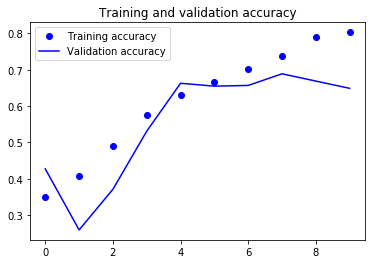

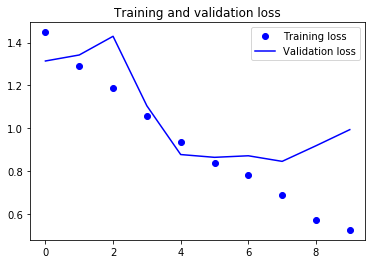

In [94]:
accuracy = img_train_dropout.history['acc']
val_accuracy = img_train_dropout.history['val_acc']
loss = img_train_dropout.history['loss']
val_loss = img_train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predict Labels

In [95]:
predicted_classes = img_model.predict(test_X)

In [96]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [97]:
predicted_classes.shape, test_Y.shape

((443,), (443,))

* bathroom: 0
* bedroom: 1
* kitchen: 2
* livingroom: 3

Found 260 correct labels
58.690745 prcnt correct labels


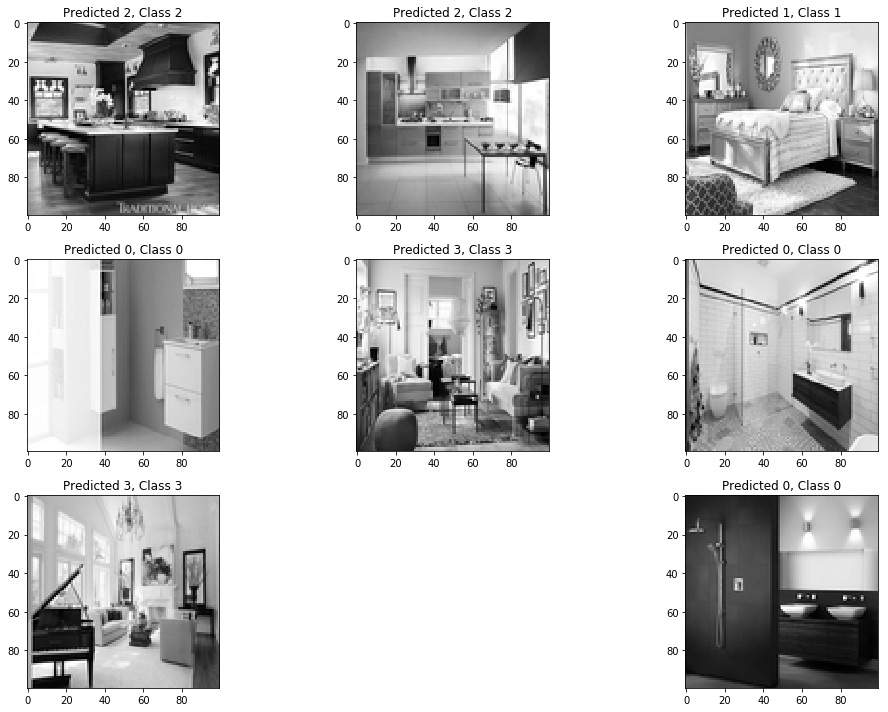

In [98]:
figure(figsize=(15, 10))
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
print("%f prcnt correct labels" % (len(correct) * 100 / len(test_Y)))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

* bathroom: 0
* bedroom: 1
* kitchen: 2
* livingroom: 3

Found 183 incorrect labels
41.309255 prcnt incorrect labels


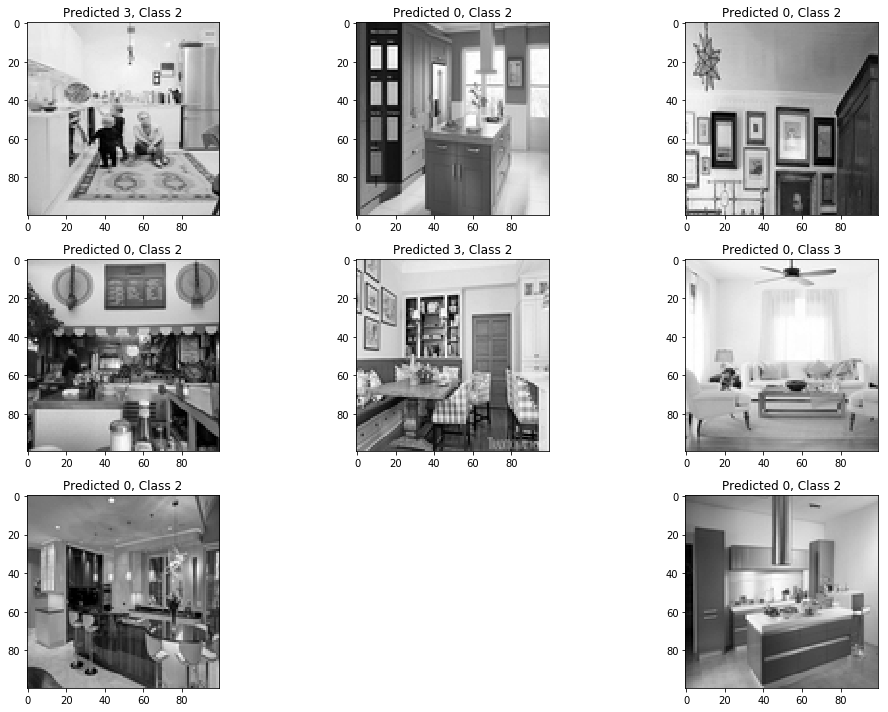

In [99]:
figure(figsize=(15, 10))
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
print("%f prcnt incorrect labels" % (len(incorrect) * 100 / len(test_Y)))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

### Classification Report

In [100]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.42      0.91      0.58       109
    Class 1       0.59      0.30      0.40        57
    Class 2       0.89      0.47      0.61       187
    Class 3       0.69      0.63      0.66        90

avg / total       0.69      0.59      0.58       443



### Adding Dropout into the Network, more apochs, smaller alpha

In [101]:
batch_size = 50
epochs = 33
num_classes = nClasses

In [102]:
img_model = Sequential()
img_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(100,100,1)))
img_model.add(LeakyReLU(alpha=0.1))
img_model.add(MaxPooling2D((2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.01))
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.25))
img_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
img_model.add(LeakyReLU(alpha=0.01))                  
img_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
img_model.add(Dropout(0.4))
img_model.add(Flatten())
img_model.add(Dense(128, activation='linear'))
img_model.add(LeakyReLU(alpha=0.01))           
img_model.add(Dropout(0.3))
img_model.add(Dense(num_classes, activation='softmax'))

In [103]:
img_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 64)        0         
__________

In [104]:
### Complile
img_model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

In [105]:
### Train model
img_train_dropout_100 = img_model.fit(train_X, train_label, batch_size=batch_size,
                    epochs=epochs,verbose=1, validation_data=(valid_X, valid_label))

Train on 2004 samples, validate on 501 samples
Epoch 1/33
2004/2004 [==============================] - 34s 17ms/step - loss: 1.3887 - acc: 0.3847 - val_loss: 1.3075 - val_acc: 0.4271
Epoch 2/33
2004/2004 [==============================] - 34s 17ms/step - loss: 1.2574 - acc: 0.4491 - val_loss: 1.1693 - val_acc: 0.5549
Epoch 3/33
2004/2004 [==============================] - 33s 17ms/step - loss: 1.0721 - acc: 0.5589 - val_loss: 1.0571 - val_acc: 0.5749
Epoch 4/33
2004/2004 [==============================] - 33s 17ms/step - loss: 0.9936 - acc: 0.5848 - val_loss: 1.0042 - val_acc: 0.5868
Epoch 5/33
2004/2004 [==============================] - 33s 16ms/step - loss: 0.9369 - acc: 0.6287 - val_loss: 0.9279 - val_acc: 0.6028
Epoch 6/33
2004/2004 [==============================] - 33s 17ms/step - loss: 0.8607 - acc: 0.6692 - val_loss: 0.8400 - val_acc: 0.6707
Epoch 7/33
2004/2004 [==============================] - 33s 17ms/step - loss: 0.7943 - acc: 0.6911 - val_loss: 0.8490 - val_acc: 0.6547
E

In [106]:
### Evaluate
test_eval_100 = img_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [107]:
print('Test loss:', test_eval_100[0])
print('Test accuracy:', test_eval_100[1])

Test loss: 1.5386678424430487
Test accuracy: 0.6997742675766181


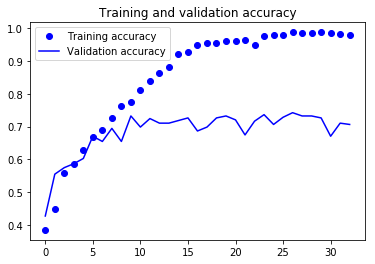

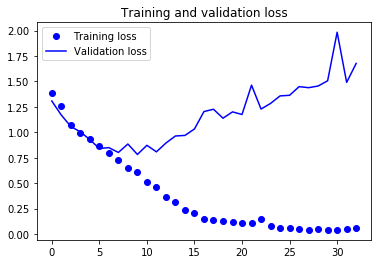

In [108]:
accuracy = img_train_dropout_100.history['acc']
val_accuracy = img_train_dropout_100.history['val_acc']
loss = img_train_dropout_100.history['loss']
val_loss = img_train_dropout_100.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [109]:
### Predicting labels
predicted_classes = img_model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_Y.shape

((443,), (443,))

* bathroom: 0
* bedroom: 1
* kitchen: 2
* livingroom: 3

Found 308 correct labels
69.525959 prcnt correct labels


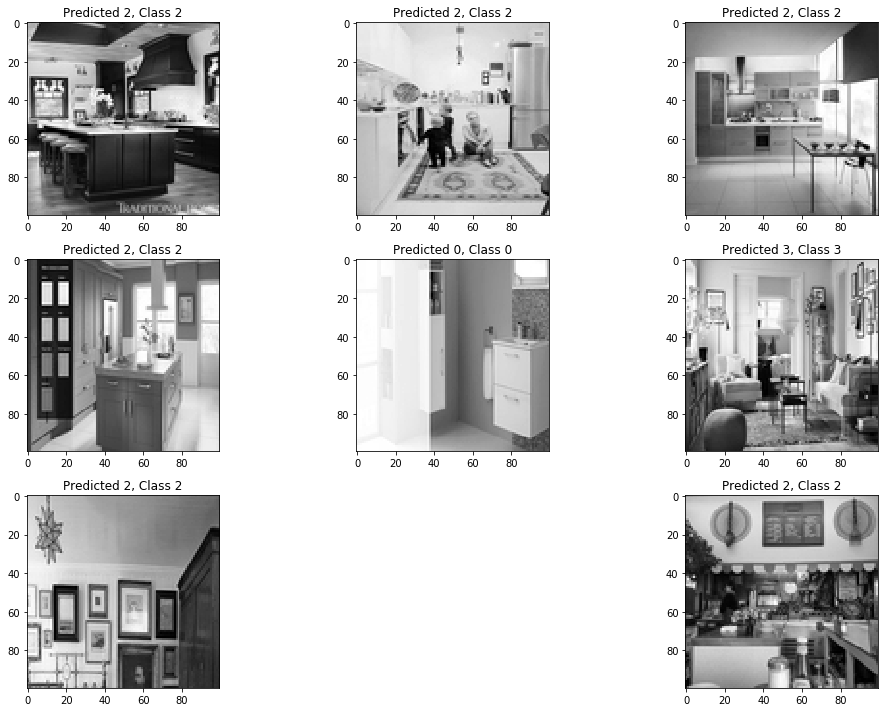

In [110]:
figure(figsize=(15, 10))
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
print("%f prcnt correct labels" % (len(correct) * 100 / len(test_Y)))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 135 incorrect labels
30.474041 prcnt incorrect labels


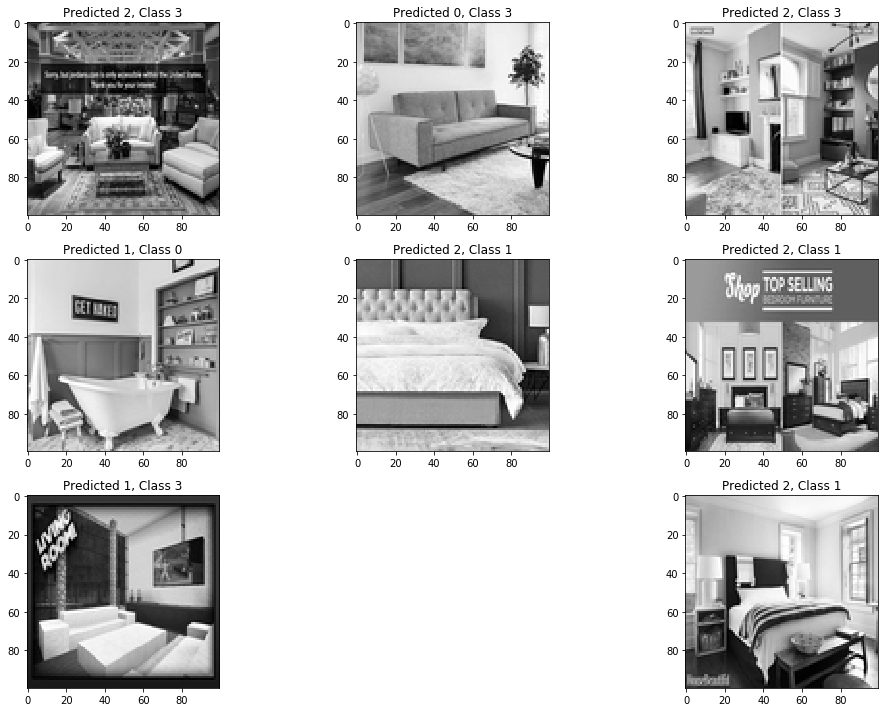

In [111]:
figure(figsize=(15, 10))
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
print("%f prcnt incorrect labels" % (len(incorrect) * 100 / len(test_Y)))
for i, incorrect in enumerate(random.sample(list(incorrect), 9)):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(100,100), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()